## ResNet-18

Входной слой:
* Размер входа: Изображения преобразуются в градации серого с 3 каналами и изменяются до размера 224×224 пикселей.

Слой Conv1:
* Тип: Сверточный слой.
* Количество фильтров: 64.
* Размер фильтра: 7×7.
* Шаг (stride): 2.
* Отступ (padding): 3.
* Функция активации: ReLU.

Слой Pooling1:
* Тип: Макс-пулинг (Max Pooling).
* Размер ядра: 3×3.
* Шаг (stride): 2.
* Функция активации: Отсутствует (только подвыборка).

Слой Layer1:
* Тип: Остаточный блок (Residual Block).
* Количество блоков: 2.
* Количество фильтров в каждом блоке: 64.
* Размер фильтров: 3×3.
* Функция активации: ReLU.

Слой Layer2:
* Тип: Остаточный блок.
* Количество блоков: 2.
* Количество фильтров в каждом блоке: 128.
* Размер фильтров: 3×3.
* Функция активации: ReLU.

Слой Layer3:
* Тип: Остаточный блок.
* Количество блоков: 2.
* Количество фильтров в каждом блоке: 256.
* Размер фильтров: 3×3.
* Функция активации: ReLU.

Слой Layer4:
* Тип: Остаточный блок.
* Количество блоков: 2.
* Количество фильтров в каждом блоке: 512.
* Размер фильтров: 3×3.
* Функция активации: ReLU.

Слой Global Average Pooling:
* Тип: Глобальная средняя подвыборка.
* Описание: Преобразует выходные тензоры из размерности 512×7×7 в вектор размерности 512.

Слой FC (Полносвязанный слой):
* Тип: Полносвязанный слой.
* Вход: 512 нейронов (признаков).
* Выход: 101 нейрон (по количеству классов в Caltech101).
* Функция активации: Softmax (неявно реализована через функцию потерь CrossEntropyLoss).

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision.models import ResNet18_Weights

In [ ]:
# --- 1. Подготовка данных ---
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.Caltech101(root='./data', download=True, transform=transform_train)
testset = torchvision.datasets.Caltech101(root='./data', download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

classes = trainset.categories

Downloading...
From (original): https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
From (redirected): https://drive.usercontent.google.com/download?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp&confirm=t&uuid=4733f0c1-3139-4cbb-8ccb-7361ebda7a12
To: /content/data/caltech101/101_ObjectCategories.tar.gz
100%|██████████| 132M/132M [00:03<00:00, 37.2MB/s]


Extracting ./data/caltech101/101_ObjectCategories.tar.gz to ./data/caltech101


Downloading...
From (original): https://drive.google.com/uc?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m
From (redirected): https://drive.usercontent.google.com/download?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m&confirm=t&uuid=f6bf7609-4367-44d8-81a0-94b859ad0fa9
To: /content/data/caltech101/Annotations.tar
100%|██████████| 14.0M/14.0M [00:00<00:00, 49.5MB/s]


Extracting ./data/caltech101/Annotations.tar to ./data/caltech101
Files already downloaded and verified


In [ ]:
# --- 2. Архитектура модели ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(512, len(classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 202MB/s]


In [ ]:
# --- 3. Обучение ---
num_epochs = 10
train_loss_history, test_loss_history, test_accuracy_history = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss_history.append(running_loss / len(trainloader))

    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss_history.append(test_loss / len(testloader))
    accuracy = 100 * correct / total
    test_accuracy_history.append(accuracy)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss_history[-1]:.4f}, Test Loss: {test_loss_history[-1]:.4f}, Test Accuracy: {accuracy:.2f}%')
    scheduler.step()

Epoch 1, Train Loss: 0.6144, Test Loss: 0.1687, Test Accuracy: 94.94%
Epoch 2, Train Loss: 0.6004, Test Loss: 0.1560, Test Accuracy: 95.27%
Epoch 3, Train Loss: 0.5853, Test Loss: 0.1460, Test Accuracy: 95.40%
Epoch 4, Train Loss: 0.5459, Test Loss: 0.1450, Test Accuracy: 95.45%
Epoch 5, Train Loss: 0.5298, Test Loss: 0.1342, Test Accuracy: 95.78%
Epoch 6, Train Loss: 0.4982, Test Loss: 0.1307, Test Accuracy: 96.00%
Epoch 7, Train Loss: 0.4922, Test Loss: 0.1274, Test Accuracy: 96.04%
Epoch 8, Train Loss: 0.4952, Test Loss: 0.1238, Test Accuracy: 96.12%
Epoch 9, Train Loss: 0.5058, Test Loss: 0.1242, Test Accuracy: 96.07%
Epoch 10, Train Loss: 0.4999, Test Loss: 0.1214, Test Accuracy: 96.25%


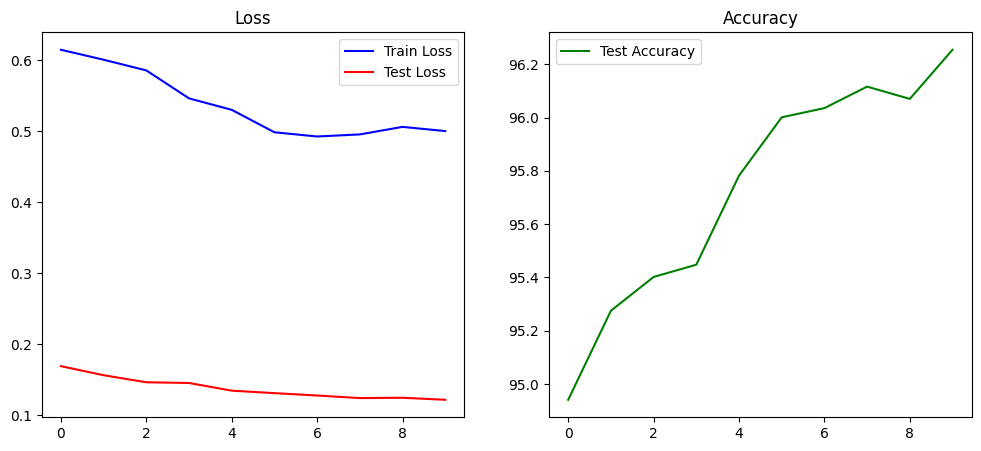

In [ ]:
# --- 4. Графики ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss_history, label='Train Loss', color='blue')
plt.plot(test_loss_history, label='Test Loss', color='red')
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(test_accuracy_history, label='Test Accuracy', color='green')
plt.legend()
plt.title("Accuracy")
plt.show()


In [ ]:
# --- 5. Сохранение модели и изображения ---
index = np.random.randint(len(testset))
image, label = testset[index]
image_pil = transforms.ToPILImage()(image)
image_pil.save("caltech101_test_image.png")

torch.save(model.state_dict(), "caltech101_resnet18.pth")


In [ ]:
# --- 6. Загрузка и предсказание ---
loaded_model = torchvision.models.resnet18(pretrained=False)
loaded_model.fc = nn.Linear(512, len(classes))
loaded_model.load_state_dict(torch.load("caltech101_resnet18.pth"))
loaded_model = loaded_model.to(device)
loaded_model.eval()

loaded_image = Image.open("caltech101_test_image.png")
loaded_image_tensor = transform_test(loaded_image).unsqueeze(0).to(device)

with torch.no_grad():
    output = loaded_model(loaded_image_tensor)
    _, predicted_class = torch.max(output, 1)

predicted_class_name = classes[predicted_class.item()]
true_class_name = classes[label]

print(f"Предсказанный класс: {predicted_class_name}")
print(f"Истинный класс: {true_class_name}")
if predicted_class_name == true_class_name:
    print("Предсказание верное!")
else:
    print("Предсказание неверно!")


Предсказанный класс: watch
Истинный класс: watch
Предсказание верное!


<ipython-input-23-d3c02a0378ce>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("caltech101_resnet18.pth"))
